# 3: Sampling the Imaginary

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import torch
import pyro

### Code 3.1
Calculate the probability of being a vampire if the test returns positive

In [2]:
pr_pos_vamp = 0.95
pr_pos_mortal = 0.01
pr_vamp = 0.001
pr_pos = pr_pos_vamp * pr_vamp + pr_pos_mortal * (1 - pr_vamp)
pr_vamp_pos = pr_pos_vamp * pr_vamp / pr_pos
pr_vamp_pos

0.08683729433272395

### Code 3.2
Grid approximation refresher

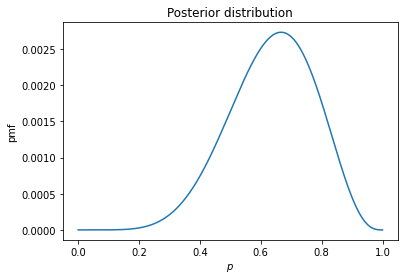

In [3]:
p_grid = np.linspace(0, 1, 1000)
prob_p = np.ones(1000)
prob_data = st.binom(n=9, p=p_grid).pmf(6)
posterior = prob_data * prob_p
posterior /= sum(posterior)
plt.plot(p_grid, posterior)
plt.title("Posterior distribution")
plt.xlabel("$p$")
plt.ylabel("pmf")
plt.show()

### Code 3.3
Draw 10,000 samples from the above posterior

In [4]:
samples = np.random.choice(p_grid, p=posterior, size=10000)

### Code 3.4
Scatter plot of the samples

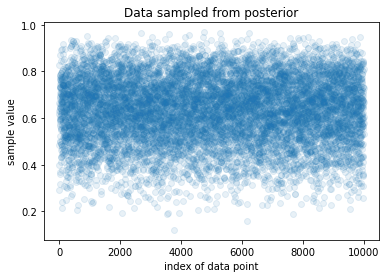

In [5]:
plt.scatter(range(len(samples)), samples, alpha=0.1)
plt.title("Data sampled from posterior")
plt.xlabel("index of data point")
plt.ylabel("sample value")
plt.show()

### Code 3.5
Plot a kernel density estimate (KDE) of the distribution

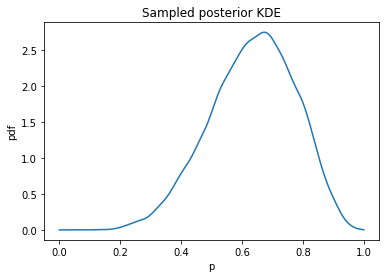

In [6]:
x = np.linspace(0, 1, 1000)
y = st.kde.gaussian_kde(samples, bw_method=0.15).pdf(x)
plt.plot(x, y)
plt.title("Sampled posterior KDE")
plt.xlabel("p")
plt.ylabel("pdf")
plt.show()

### Code 3.6
Calculate the probability of $p < 0.5$ using the posterior from the grid approximation

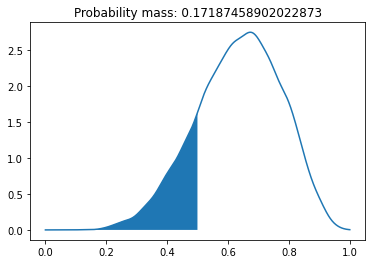

In [7]:
plt.plot(p_grid, y)
plt.fill_between(x[x<0.5], y[x<0.5], 0)
p = posterior[p_grid<0.5].sum()
plt.title(f"Probability mass: {p}")
plt.show()

### Code 3.7
Calculate the probability of $p < 0.5$ using the samples from the posterior

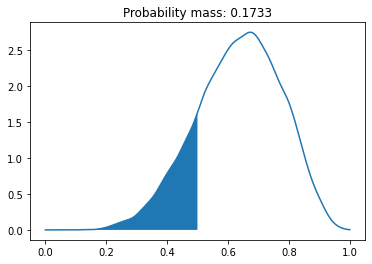

In [8]:
plt.plot(p_grid, y)
plt.fill_between(x[x<0.5], y[x<0.5], 0)
p = (samples < 0.5).sum()/len(samples)
plt.title(f"Probability mass: {p}")
plt.show()

### Code 3.8
Calculate the posterior probability of being between 0.5 and 0.75

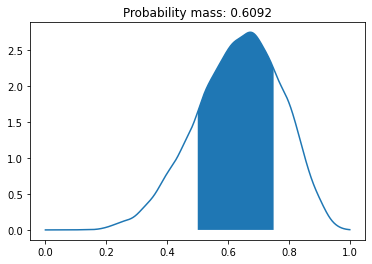

In [9]:
plt.plot(p_grid, y)
mask = (0.5<x) & (x<0.75)
plt.fill_between(x[mask], y[mask], 0)
p = ((0.5 < samples) & (samples < 0.75)).sum()/len(samples)
plt.title(f"Probability mass: {p}")
plt.show()

### Code 3.9
Find the lower 80% quantile of the posterior using samples

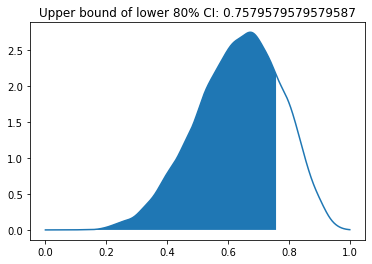

In [10]:
plt.plot(p_grid, y)
q = np.quantile(samples, 0.8)
mask = (x<q)
plt.fill_between(x[mask], y[mask], 0)
plt.title(f"Upper bound of lower 80% CI: {q}")
plt.show()

### Code 3.10
Find the 10 and 90th percentiles

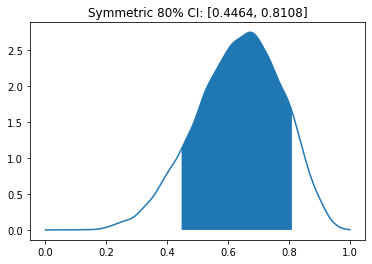

In [11]:
plt.plot(p_grid, y)
q1, q2 = np.quantile(samples, [0.1, 0.9])
mask = (q1<x) & (x<q2)
plt.fill_between(x[mask], y[mask], 0)
plt.title(f"Symmetric 80% CI: [{q1:.4f}, {q2:.4f}]")
plt.show()

### Code 3.11
Compute the posterior for the 3 successes in 3 trials distribution; this one is a bit more asymmetric

In [12]:
# Calculate posterior using grid approx
p_grid = np.linspace(0, 1, 1000)
prior = np.ones(len(p_grid))
likelihood = st.binom(n=3, p=p_grid).pmf(3)
posterior = likelihood * prior
posterior /= posterior.sum()
# Sample from posterior
samples = np.random.choice(p_grid, size=10000, p=posterior)

### Code 3.12
Compute 50% symmetric credible interval

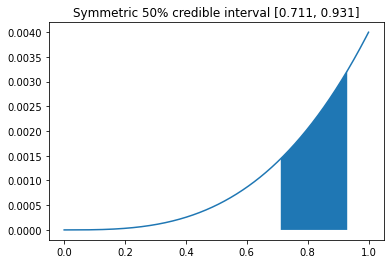

In [13]:
plt.plot(p_grid, posterior)
q1, q2 = np.quantile(samples, [0.25, 0.75])
mask = (q1<p_grid) & (p_grid<q2)
x = p_grid[mask]
y = posterior[mask]
plt.fill_between(x, y, 0)
plt.title(f"Symmetric 50% credible interval [{q1:.3f}, {q2:.3f}]")
plt.show()

### Code 3.13
Compute the 50% HPDI (Highest Posterior Density Interval), which is the densest interval containing the given probability mass

In [14]:
# This looks really useful, I'm going to save it for later
def HPDI(samples, prob):
    samples = sorted(samples)
    N = len(samples)
    W = int(round(N*prob))
    min_interval = float('inf')
    bounds = [0, W]
    for i in range(N-W):
        interval = samples[i+W] - samples[i]
        if interval < min_interval:
            min_interval = interval
            bounds = [i, i+W]
    return samples[bounds[0]], samples[bounds[1]]

In [15]:
HPDI(samples, 0.5)

(0.8428428428428428, 1.0)

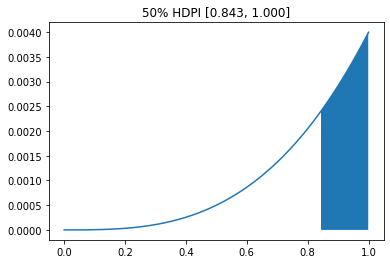

In [16]:
plt.plot(p_grid, posterior)
q1, q2 = HPDI(samples, 0.5)
mask = (q1<p_grid) & (p_grid<q2)
x = p_grid[mask]
y = posterior[mask]
plt.fill_between(x, y, 0)
plt.title(f"50% HDPI [{q1:.3f}, {q2:.3f}]")
plt.show()

### Code 3.14
Compute the MAP estimate for the above example using the grid posterior

In [17]:
p_grid[np.argmax(posterior)]

1.0

### Code 3.15
Get a MAP estimate from the samples

In [18]:
counts, bins = np.histogram(samples, bins=50)
i = np.argmax(counts)
(bins[i] + bins[i+1])/2

0.9911811811811813

### Code 3.16
What are the mean/median of the samples?

In [19]:
print(f"mean: {samples.mean()}")
print(f"median: {np.median(samples)}")

mean: 0.8024720720720722
median: 0.8428428428428428


### Code 3.17
Compute the expected loss from guessing the point estimate $\hat{p}$, where $L(\hat{p}) = |\hat{p} - p|$ ($p$ is the "true" value), for the value $\hat{p} = 0.5$

In [20]:
sum(posterior * abs(0.5 - p_grid))

0.3128751874998122

### Code 3.18/3.19
Calculate the loss curve over all values of $\hat{p}$ and find the one that minimizes $L$

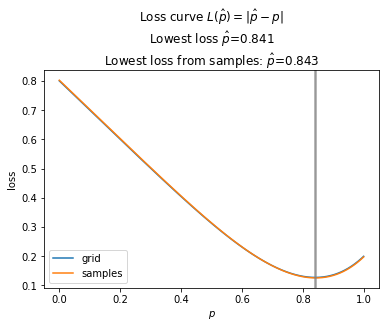

In [22]:
loss = [sum(posterior * abs(p - p_grid)) for p in p_grid] # Using grid estimate posterior
loss_sampled = [abs(p - samples).mean() for p in p_grid] # Using posterior samples
min_loss = p_grid[np.argmin(loss)]
min_loss_sampled = p_grid[np.argmin(loss_sampled)]
plt.plot(p_grid, loss, label="grid")
plt.plot(p_grid, loss_sampled, label="samples")
plt.axvline(min_loss, color="grey", alpha=0.75)
plt.axvline(min_loss_sampled, color="grey", alpha=0.75)
plt.title(
    "Loss curve $L(\hat{p}) = |\hat{p} - p|$\nLowest loss $\hat{p}$="
    f"{min_loss:.3f}\n""Lowest loss from samples: $\hat{p}$="
    f"{min_loss_sampled:.3f}"
)
plt.xlabel("$p$")
plt.ylabel("loss")
plt.legend()
plt.show()

### Code 3.20
Compute the probability of 0, 1, 2 successes out of 2 trials with $p=0.7$

In [23]:
st.binom(n=2, p=0.7).pmf([0, 1, 2])

array([0.09, 0.42, 0.49])

### Code 3.21/3.22
Sample from the above distribution

In [24]:
st.binom(n=2, p=0.7).rvs(10)

array([1, 1, 2, 2, 2, 1, 2, 2, 0, 1])

### Code 3.23
Sample 100,000 times to verify that it is the sample proportion as expected by the pmf

In [25]:
W = st.binom(n=2, p=0.7).rvs(100_000)
vals, counts = np.unique(W, return_counts=True)
W = np.stack([vals, counts/len(W)])
print(W)

[[0.      1.      2.     ]
 [0.09041 0.41871 0.49088]]


### Code 3.24
Simulate 9 tosses of the globe, like before

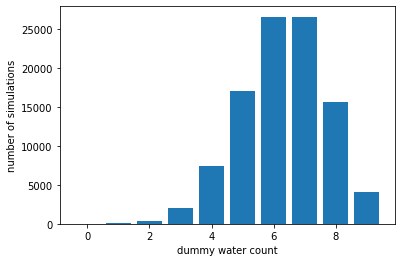

In [26]:
W = st.binom(n=9, p=0.7).rvs(100_000)
vals, counts = np.unique(W, return_counts=True)
plt.bar(vals, counts)
plt.xlabel("dummy water count")
plt.ylabel("number of simulations")
plt.show()

### Code 3.25/3.26
Calculate the posterior predictive distribution for the data (W counts) using the samples we drew from earlier

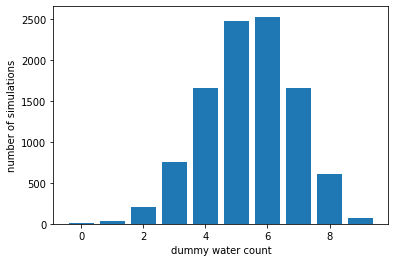

In [27]:
# 10k samples from just the value p=0.6 creates an overconfident
# data prediction
W = st.binom(n=9, p=0.6).rvs(10_000) 
vals, counts = np.unique(W, return_counts=True)
plt.bar(vals, counts)
plt.xlabel("dummy water count")
plt.ylabel("number of simulations")
plt.show()

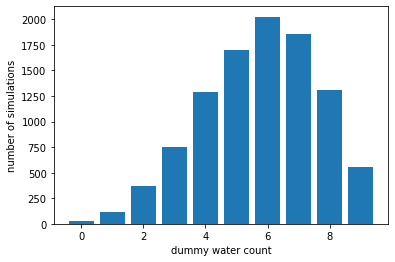

In [28]:
# If you use the samples from the posterior for $p$, it 
# preserves the uncertainty much better
samples = st.beta(6+1, 3+1).rvs(10_000) # sample 10k times from analytic posterior (W=6, L=3)
W = st.binom(n=9, p=samples).rvs() # sample from posterior predictive
vals, counts = np.unique(W, return_counts=True)
plt.bar(vals, counts)
plt.xlabel("dummy water count")
plt.ylabel("number of simulations")
plt.show()

### Code 3.26.1
Create plots looking at the longest consecutive run length, and number of switches for the data generated from the posterior predictive distribution

In [29]:
# Generate the actual success/failures rather than counts from the PPD
W = st.bernoulli.rvs(samples, size=[9, len(samples)]).T
# count longest consecutive sequence
max_len = np.ones(len(samples))
cur_len = np.ones(len(samples))
num_switches = np.zeros(len(samples))
for i in range(9-1):
    cons = (W[:,i] == W[:,i+1])
    cur_len[cons] += 1
    cur_len[~cons] = 1
    max_len = np.maximum(max_len, cur_len)
    num_switches += ~cons

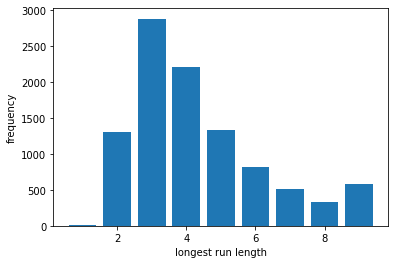

In [30]:
vals, counts = np.unique(max_len, return_counts=True)
plt.bar(vals, counts)
plt.xlabel("longest run length")
plt.ylabel("frequency")
plt.show()

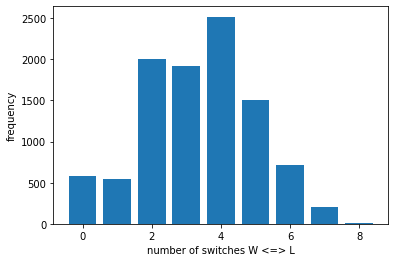

In [31]:
vals, counts = np.unique(num_switches, return_counts=True)
plt.bar(vals, counts)
plt.xlabel("number of switches W <=> L")
plt.ylabel("frequency")
plt.show()

## Practice

### 3E1-3E7 (including Code 3.27)
Generate some samples for the globe-tossing model

In [32]:
p_grid = np.linspace(0, 1, 1000)
prior = np.ones(len(p_grid))
likelihood = st.binom(n=9, p=p_grid).pmf(6)
posterior = likelihood * prior
posterior /= posterior.sum()
np.random.seed(100)
samples = np.random.choice(p_grid, p=posterior, size=10_000)

Now answer some questions about the distribution using the samples

In [34]:
# 3E1: How much posterior probability lies below p=0.2?
(samples < 0.2).sum()/len(samples)

0.001

In [35]:
# 3E2: How much posterior probability lies above p=0.8?
(samples > 0.8).sum()/len(samples)

0.1209

In [36]:
# 3E3: How much posterior probability lies between p=0.2 and p=0.8?
((0.2 < samples) & (samples < 0.8)).sum()/len(samples)

0.8781

In [37]:
# 3E4: 20% of the posterior probability lies below which value of p?
np.quantile(samples, 0.2)

0.5155155155155156

In [39]:
# 3E5: 20% of the posterior probability lies above which value of p?
np.quantile(samples, 0.8)

0.7597597597597597

In [41]:
# 3E6: Which values of p contain the narrowest interval equal to
# 66% of the posterior probability?
HPDI(samples, 0.66)

(0.5165165165165165, 0.7887887887887888)

In [42]:
q1 = 0.66/2
q2 = 1 - 0.66/2
np.quantile(samples, (q1, q2))

array([0.57657658, 0.70603604])

### 3M1
Suppose the globe-tossinge data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

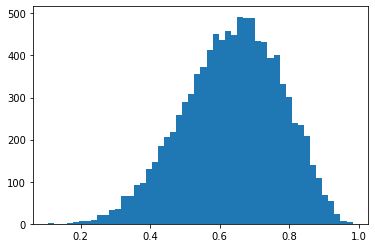

In [43]:
p_grid = np.linspace(0, 1, 1000)
prior = np.ones(len(p_grid))
likelihood = st.binom(n=15, p=p_grid).pmf(8)
posterior = likelihood * prior
posterior /= posterior.sum()
plt.hist(samples, bins=50)
plt.show()

### 3M2
Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPDI for $p$.

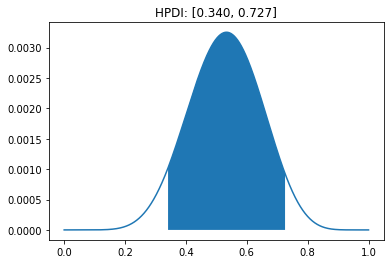

In [44]:
samples = np.random.choice(p_grid, p=posterior, size=10_000)
q1, q2 = HPDI(samples, 0.90)
plt.plot(p_grid, posterior)
mask = (q1 < p_grid) & (p_grid < q2)
plt.fill_between(p_grid[mask], posterior[mask], 0)
plt.title(f"HPDI: [{q1:.3f}, {q2:.3f}]")
plt.show()

### 3M3
Constuct a posterior predictive check for this model and data. This means simulate the distribution of samples, avaraging over the posterior uncertainty in $p$. What is the probability of observing 8 water in 15 tosses?

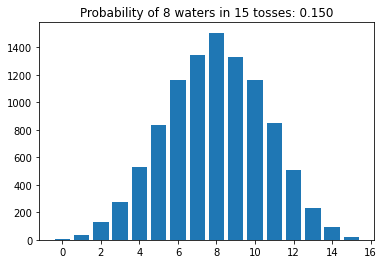

In [53]:
W = st.binom.rvs(n=15, p=samples)
vals, counts = np.unique(W, return_counts=True)
plt.bar(vals, counts)
p8 = (counts[vals==8]/counts.sum()).item()
plt.title(f"Probability of 8 waters in 15 tosses: {p8:.3f}")
plt.show()

### 3M4
Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses

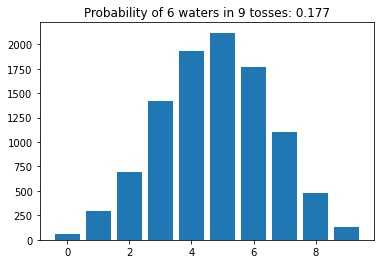

In [54]:
W = st.binom.rvs(n=9, p=samples)
vals, counts = np.unique(W, return_counts=True)
plt.bar(vals, counts)
p6 = (counts[vals==6]/counts.sum()).item()
plt.title(f"Probability of 6 waters in 9 tosses: {p6:.3f}")
plt.show()